In [78]:
import numpy as np
from scipy import integrate

# All constants and comments describing them are from Widiasih, referenced in references.bib
# TODO: Create proper bibliography with BibTeX in Markdown cell

Q = 343 # Current value of solar insolation
ocean_albedo = 0.32 # Amount of radiation reflected by this surface
ice_albedo = 0.62 # Amount of radiation reflected by this surface
C = 3.04 # Constant traditionally chosen so that one of the equilibria fits the current climate with an ice line near the pole
critical_temperature = -10 # Celsius value at which liquid water will freeze
R = 12.6 # Heat capacity of the surface of the planet
M = 25 # Steepness of the albedo function near the ice line
epsilon = 0.01 # Constant to control rate of ice line movement

# approximation of both the Stephan-Boltzman's law of black body radiation and the greenhouse gas effect on the atmosphere (A + BT)
A = 202
B = 1.9

num_of_latitude_steps = 200
latitude_range = np.linspace(0, 1, num_of_latitude_steps) # 0 to 1 goes from the equator to the pole in y
initial_temperature_equator = 35 # Sample Celsius from weather on 8/2/2023
initial_temperature_pole = -2 # Sample Celsius
initial_temperature_profile = np.linspace(initial_temperature_equator, initial_temperature_pole, num_of_latitude_steps)

num_of_time_steps = 1000
time_beginning = 0
time_end = 1
delta_time = (time_end - time_beginning) / num_of_time_steps
time_range = np.linspace(time_beginning, time_end, num_of_time_steps)

initial_eta = 0.2 # eta at 0 is snowball, eta at 1 is no ice

temperatures_matrix = np.empty((num_of_latitude_steps, num_of_time_steps))
temperatures_matrix[:, 0] = initial_temperature_profile
eta_matrix = np.empty(num_of_time_steps)
eta_matrix[0] = initial_eta

def diff_equ_budyko(eta, y, T, Q, ocean_albedo, ice_albedo, C, R, M, current_time_step, temperatures_matrix):
    """Returns the result of the continuous differential equation referred to related to equation 2.5"""
    s = legendre_latitude_distr(y)
    albedo = ice_line_dependent_albedo(eta, y, ocean_albedo, ice_albedo, M)
    integral = integral_temp_profile(temperatures_matrix[:, current_time_step - 1], y)

    return_value = (1 / R) * (Q * s * (1 - albedo) - (A + B * T) - C * (T - integral))
    return return_value

def legendre_latitude_distr(y):
    """The function referred to as s(y) calculating the distribution of radiation based on latitude."""
    return 1 - (0.482 * (((3 * (y ** 2)) - 1) / 2))

def ice_line_dependent_albedo(eta, y, ocean_albedo, ice_albedo, M):
    """Returns the albedo at location y."""
    return (ocean_albedo + ice_albedo) / 2 + ((ice_albedo - ocean_albedo) / 2) * np.tanh(M * (y - eta))

def integral_temp_profile(T_i, y):
    """Returns the integral from 0 to 1 of the previous column of """
    return integrate.trapezoid(T_i, y)

def ice_line_equation(eta, critical_temperature, epsilon, current_time_step, temperatures_matrix):
    """Returns the result of the ice line equation at eta, representing the change in the ice line."""
    T_i = temperatures_matrix[:, current_time_step - 1]
    eta_temp = T_i[round(eta * num_of_latitude_steps) - 1] # May have to check again if this is correct
    return epsilon * (eta_temp - critical_temperature)

for i in range(1, num_of_time_steps):
    new_eta = eta_matrix[i - 1] + ice_line_equation(eta_matrix[i - 1], critical_temperature, epsilon, i, temperatures_matrix)
    # New etas are bounded between 0 and 1
    if new_eta < 0:
        eta_matrix[i] = 0
    elif new_eta > 1:
        eta_matrix[i] = 1
    else:
        eta_matrix[i] = new_eta
    temperatures_matrix[:, i] = temperatures_matrix[:, i - 1] + diff_equ_budyko(eta_matrix[i], latitude_range, temperatures_matrix[:, i - 1], Q, ocean_albedo, ice_albedo, C, R, M, i, temperatures_matrix)

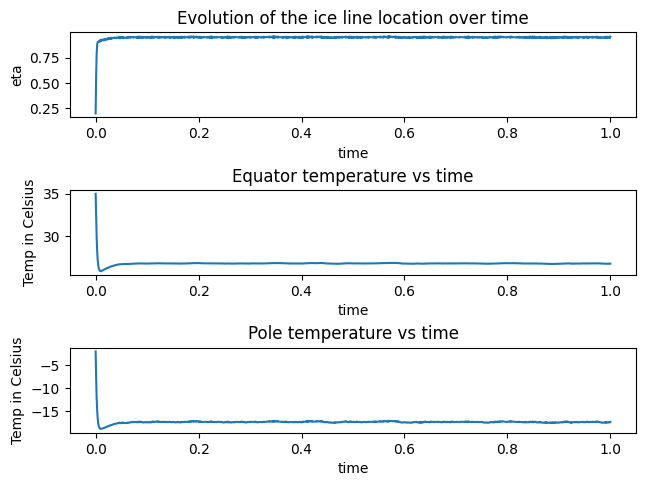

In [79]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3)
axs[0].plot(time_range, eta_matrix)
axs[0].set(xlabel="time", ylabel="eta", title="Evolution of the ice line location over time")

axs[1].plot(time_range, temperatures_matrix[0, :])
axs[1].set(xlabel="time", ylabel="Temp in Celsius", title="Equator temperature vs time")

axs[2].plot(time_range, temperatures_matrix[num_of_latitude_steps - 1, :])
axs[2].set(xlabel="time", ylabel="Temp in Celsius", title="Pole temperature vs time")

fig.tight_layout(pad=0.5)

plt.show()
# Results seemed to be inverted (i.e. the world getting colder as the ice line retreats)
# There may be a problem with ice line calculations, will be addressed in the next commit

```{bibliography}
```